# DCGAN

본 Notebook은 Alec Radford et al. 의 논문 'Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks' 내용을 해석하여 이해하고, 이를 모듈화하는 것을 목적으로 합니다. 

*Learning reusable feature representations from large unlabeled datasets has been an area of active research. In the context of computer vision, one can leverage the prectically unlimited amount of unlabeled images and videos to learn good intermediate representations, which can then be used on a variety of supervised learning tasks such as image classifiacation. *

*We propose that one way to build good image representations is by training Generative Adversarial Networks (GANs, Goodfellow et al, 2014), and later reusing parts of the generator and discriminator networks as feature extractors for supervised tasks. GANs provide an attractive alternative to maximum likelihood techniques. *

Ian Goodfellow의 GAN이 발표되고 나서 다양한 연구 분야에서 GAN을 활용하기 시작한 이래로, 쓸만한 output을 얻기 위한 trainig은 notorious 라는 수식이가 자연스레 붙을 정도로, 실제 적용하는 데에는 Mode collapse 등의 불안정한 구조라는 문제가 내재되어 있다. [NIPS 2016 Tutorial](https://www.youtube.com/watch?v=AJVyzd0rqdc)

*One can additionally argue that their learning process and the lack of a heuristic cost function (such as pixel-wise independent mean-square error) are attractive to representation learning. <span style="color:red"> GANs have been known to be unstable to train, often resulting in generators that produce nonsensical outputs. </span> There has been very limited published research in tyring to understand and visualize what GANs learn, and the intermediate representations of multi-layer GANs. *


In [1]:
import tensorflow as tf

/home/icell/anaconda3/envs/hog/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Dataset

논문 中 4. Details of Adversarial training

*We trained DCGANs on three datasets, Large-scale Scene Understanding (LSUN) (Yu et al. 2015), Imagenet-1k and a newly assembled Faces dataset. Details on the usage of each of these datasets are given below.*

침실(Bedroom) Dataset은 Trainig 총 3,033,042장 (43 Gb), Vaildation 300장으로 구성되어 있다.  

#### Download
LSUN Chanllenge site(http://lsun.cs.princeton.edu/2017/)에 가면 LSUN Dataset Category 및 도전과제에 대한 설명이 자세히 나와있다. 그리고 전
체 Dataset을 내려받거나 Dataset Category 별로 받을 수 있는 git 소스코드도 함께 제공하고 있다.

본 Notebook에서는 LSUN Download Git(https://github.com/fyu/lsun.git)을 이용해서, 논문에서 사용한 침실(Bedroom) 이미지를 내려받아 사용한다.

#### Script
- git clone https://github.com/fyu/lsun.git
- python2.7 download.py -c bedroom


### Model Architecture

논문 中 3. Approach and Model Architecture

*..**Architecture guidelines for stable Deep Convolutional GANs.** *
- *Replace any pooling layers with strided convolutions (discriminator) and <span style="color:blue">fractional-strided</span> convolutions (generator)*
- *Use batchnorm in both the generator and the discriminator.*
- *Remove fully connected hidden layers for deeper architectures.*
- *Use ReLU activation in generator for all layer except for the output, which uses Tanh.*
- *Use LeakyReLU activation in the discriminator for all layers.*

※ GAN 자료를 살펴보다보면, 종종 Deconvolutional이라는 용어가 쓰이는데 fractional-strided 가 정확한 용어라고 한다.

### Parameters

논문 中 4. Details of Adversarial training

*No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1]. All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02. In the LeakyReLU, the slope of the leak was set to 0.2 in all models. While previous GAN work has used momentum to accelerate training, we used the Adam optimizer (Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead. Additionally, we found leaving the momentum term β1 at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.*

...주요한 Parameter만 정리하면,

- Use Tanh activation function in output of generator
- Use SGD with batch size of 128
- Weight Initializer ~ N(0, sqrt(0.02))
- LeakyReLU's slope is 0.2
- Use Adam Optimizer
- learning late sets 0.001
- β1 sets 0.5


In [2]:
learning_rate = 0.001
size_filter = 5

### Generator



![](imgs/figure1.jpg)

In [3]:
def generator(z, size_of_batch, reuse=False):    
    
    with tf.variable_scope('generator') as scope:
        
        if (reuse):
            tf.get_variable_scope().reuse_variables()

        output_dimension = 64
        conv4_dimension = int(output_dimension/ 2) # 32
        conv3_dimension = int(conv4_dimension / 2) # 16
        conv2_dimension = int(conv3_dimension / 2) # 8
        conv1_dimension = int(conv2_dimension / 2) # 4
        projection_dimension = conv1_dimension

        output_channel = 3
        projection_channel = 1024
        conv1_channel = projection_channel
        conv2_channel = int(conv1_channel / 2) # 512
        conv3_channel = int(conv2_channel / 2) # 256
        conv4_channel = int(conv3_channel / 2) # 128

        # Project and reshape Layer
        hidden_layer = tf.reshape(z, [size_of_batch, projection_dimension, projection_dimension, projection_channel ])
        hidden_layer = tf.nn.relu(hidden_layer)

        # Convolusional Layer 1
        output_shape1 = [size_of_batch, conv2_dimension, conv2_dimension, conv2_channel]
        w_conv1 = tf.get_variable('w_conv1',
                                  [size_filter, size_filter, output_shape1[-1], int(hidden_layer.get_shape()[-1])],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv1 = tf.get_variable('b_conv1',
                                  [output_shape1[-1]],
                                  initializer=tf.constant_initializer(0.5))

        conv1 = tf.nn.conv2d_transpose(hidden_layer, w_conv1, 
                                       output_shape=output_shape1, strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        conv1 = tf.layers.batch_normalization(inputs=conv1, center=True, scale=True)
        conv1 = tf.nn.relu(conv1)

        # Convolusional Layer 2
        output_shape2 = [size_of_batch, conv3_dimension, conv3_dimension, conv3_channel]
        w_conv2 = tf.get_variable('w_conv2',
                                  [size_filter, size_filter, output_shape2[-1], int(conv1.get_shape()[-1])],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv2 = tf.get_variable('b_conv2',
                                  [output_shape2[-1]],
                                  initializer=tf.constant_initializer(0.5))

        conv2 = tf.nn.conv2d_transpose(conv1, w_conv2, 
                                       output_shape=output_shape2, strides=[1, 2, 2, 1],padding='SAME') + b_conv2
        conv2 = tf.layers.batch_normalization(inputs=conv2, center=True, scale=True)
        conv2 = tf.nn.relu(conv2)

        # Convolusional Layer 3
        output_shape3 = [size_of_batch, conv4_dimension, conv4_dimension, conv4_channel]
        w_conv3 = tf.get_variable('w_conv3',
                                  [size_filter, size_filter, output_shape3[-1], int(conv2.get_shape()[-1])],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv3 = tf.get_variable('b_conv3',
                                  [output_shape3[-1]],
                                  initializer=tf.constant_initializer(0.5))

        conv3 = tf.nn.conv2d_transpose(conv2, w_conv3, 
                                       output_shape=output_shape3, strides=[1, 2, 2, 1],padding='SAME') + b_conv3
        conv3 = tf.layers.batch_normalization(inputs=conv3, center=True, scale=True)
        conv3 = tf.nn.relu(conv3)

        # Convolusional Layer 4
        output_shape4 = [size_of_batch, output_dimension, output_dimension, output_channel]
        w_conv4 = tf.get_variable('w_conv4',
                                  [size_filter, size_filter, output_shape4[-1], int(conv3.get_shape()[-1])],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv4 = tf.get_variable('b_conv4',
                                  [output_shape4[-1]],
                                  initializer=tf.constant_initializer(0.5))

        conv4 = tf.nn.conv2d_transpose(conv3, w_conv4, 
                                       output_shape=output_shape4, strides=[1,2,2,1],padding='SAME') + b_conv4
        conv4 = tf.layers.batch_normalization(inputs=conv4, center=True, scale=True)
        conv4 = tf.nn.tanh(conv4)

    return conv4
 

**Tip** GAN의 Generator를 구현하는데 있어서, Network 정의만 이루어지면 임의 Noise를 주어 Image Generation이 가능하다. 물론 Z 분포에서 생성된 이미지이므로 별 의미는 없고, Network 구성을 확인하는 용도로만 참고하면 좋다. (아래 코드)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


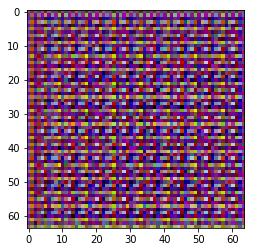

In [16]:
#Tip Code
import numpy as np
image_amount = 1
sample_noise = 4*4*1024
Z = tf.placeholder(np.float32, [None, sample_noise])
sample = generator(Z, image_amount, True)
noise = np.random.normal(-1, 1, [image_amount, sample_noise])

#Train once
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sample = sess.run(sample, feed_dict={Z: noise})

#Check
import matplotlib.pyplot as plt
my_i = sample.squeeze()
plt.imshow(my_i)
plt.show()

논문 中 Figure 1

*DCGAN generator used for LSUN scene modeling. A **<span style="color:blue">100 dimensional</span>** uniform distribution Z is projected to a samll spatial extent convolutional representation with many feature maps. A series of four fractionally-strided convolutions (in some recent paper, these are wrongly called devonvolutions) then convert this high level representation into a 64 X 64 pixel image. Notably, no fully connected or pooling layers are used*

In [4]:
import numpy as np

initial_demension=4*4*1024 # To be considered
Z = tf.placeholder(np.float32, [None, initial_demension])

### Discriminator

논문 中 3. Approach and Model Architecture

*...The first is the all convolutional net (Springenberg et al., 2014) which replaces **<span style="color:blue">deterministic spatial pooling functions (such as maxpooling)</span>** with strided convolutions, allowing the network to learn its own spatial downsampling. We use this approach in our generator, allowing it to learn its own spatial upsampling, and discriminator.*

In [5]:
def pooling_function(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [6]:
def discriminator(x, input_channel):
    with tf.variable_scope('discriminator') as scope:
        
        
        w_conv1 = tf.get_variable('w_conv1', [size_filter, size_filter, input_channel, 128],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv1 = tf.get_variable('b_conv1', [128], initializer=tf.constant_initializer(0.5))
        conv1 = tf.nn.conv2d(x, w_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
        conv1 = tf.layers.batch_normalization(inputs=conv1, center=True, scale=True, is_training=True, scope='d_bn1')
        conv1 = tf.nn.leaky_relu(conv1, alpha=0.2)
        conv1 = pooling_function(conv1)

        w_conv2 = tf.get_variable('w_conv2', [size_filter, size_filter, int(conv1.get_shape()[-1]), 256],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv2 = tf.get_variable('b_conv2', [256], initializer=tf.constant_initializer(0.5))
        conv2 = tf.nn.conv2d(conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2
        conv2 = tf.layers.batch_normalization(inputs=conv2, center=True, scale=True, is_training=True, scope='d_bn2')
        conv2 = tf.nn.leaky_relu(conv2, alpha=0.2)
        conv2 = pooling_function(conv2)
        
        w_conv3 = tf.get_variable('w_conv3', [size_filter, size_filter, int(conv2.get_shape()[-1]), 512],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv3 = tf.get_variable('b_conv3', [512], initializer=tf.constant_initializer(0.5))
        conv3 = tf.nn.conv2d(conv2, w_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3
        conv3 = tf.layers.batch_normalization(inputs=conv3, center=True, scale=True, is_training=True, scope='d_bn3')
        conv3 = tf.nn.leaky_relu(conv3, alpha=0.2)
        conv3 = pooling_function(conv3)

        w_conv4 = tf.get_variable('w_conv4', [size_filter, size_filter, int(conv3.get_shape()[-1]), 1],
                                  initializer=tf.random_normal_initializer(mean=0, stddev=0.02))
        b_conv4 = tf.get_variable('b_conv4', [1], initializer=tf.constant_initializer(0.5))
        conv4 = tf.nn.conv2d(conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4
        conv4 = tf.layers.batch_normalization(inputs=conv4, center=True, scale=True, is_training=True, scope='d_bn1')
        conv4 = tf.nn.leaky_relu(conv4, alpha=0.2)
        
        return conv4